In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install --upgrade pandas

    100% |████████████████████████████████| 10.1MB 5.0MB/s 
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


In [1]:
!ls "drive/My Drive/Colab Notebooks/data"

ls: cannot access 'drive/My Drive/Colab Notebooks/data': No such file or directory


---

In [0]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn') 

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

In [0]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc.pickle').head(20_000)

In [10]:
data.head()

,type,content,title,one_hot_label
0,fake,"[2458, 4, 27, 17625, 12, 328, 5, 25587, 416, 1...","[1732, 258, 27, 7196, 2154, 4192, 88, 43, 13, ...","[0, 1, 0]"
1,fake,"[3836, 22, 506, 3059, 67, 2, 2941, 2429, 33, 3...","[6117, 13034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
2,fake,"[7, 37481, 39852, 483, 423, 24, 42, 1837, 81, ...","[6117, 13034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
3,fake,"[7, 1790, 659, 24, 846, 6786, 5428, 17, 52, 44...","[13341, 1421, 1992, 1178, 8704, 11, 13034, 387...","[0, 1, 0]"
4,fake,"[59, 24, 216, 529, 104, 11, 34925, 133, 31, 24...","[13034, 43, 39049, 43, 76, 1588, 38, 23, 8158,...","[0, 1, 0]"


In [0]:
dfake = data[data['type'] == 'fake']
dtrue = data[data['type'] == 'truth']
dclic = data[data['type'] == 'click']

data = pd.concat([dfake.head(10000), dtrue, dclic])

del dfake, dtrue, dclic

In [11]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1645
Max len title: 13


In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/test split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.5, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

In [0]:
del data
del X_train_title, X_train_content

# LSTM

In [18]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(title_input)
x = k.layers.LSTM(200)(inp)


#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(content_input)
x2 = k.layers.LSTM(200)(inp2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)

out = k.layers.Dense(3, activation='softmax')(x)

model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(k.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1645)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1645, 300)    15000000    content_input[0][0]              
__________________________________________________________________________________________________
lstm (LSTM

In [21]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2)], validation_split=0.3)

Train on 7000 samples, validate on 3000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
7000/7000 [==============================] - 450s 64ms/sample - loss: 0.4305 - acc: 0.8643 - val_loss: 0.3135 - val_acc: 0.8933
Epoch 2/20
7000/7000 [==============================] - 432s 62ms/sample - loss: 0.2994 - acc: 0.9021 - val_loss: 0.2948 - val_acc: 0.8997
Epoch 3/20
7000/7000 [==============================] - 427s 61ms/sample - loss: 0.2719 - acc: 0.9120 - val_loss: 0.2812 - val_acc: 0.9077
Epoch 4/20
7000/7000 [==============================] - 423s 60ms/sample - loss: 0.2499 - acc: 0.9167 - val_loss: 0.2923 - val_acc: 0.9067
Epoch 5/20
7000/7000 [==============================] - 425s 61ms/sample - loss: 0.2273 - acc: 0.9254 - val_loss: 0.2839 - val_acc: 0.9123
Epoch 6/20
7000/7000 [==============================] - 440s 63ms/sample - loss: 0.2022 - acc: 0.9363 - val_loss: 0.2874 - val_acc: 0.9120
Epoch 7/20
7000/7000 [==============================] - 444s 63ms/samp

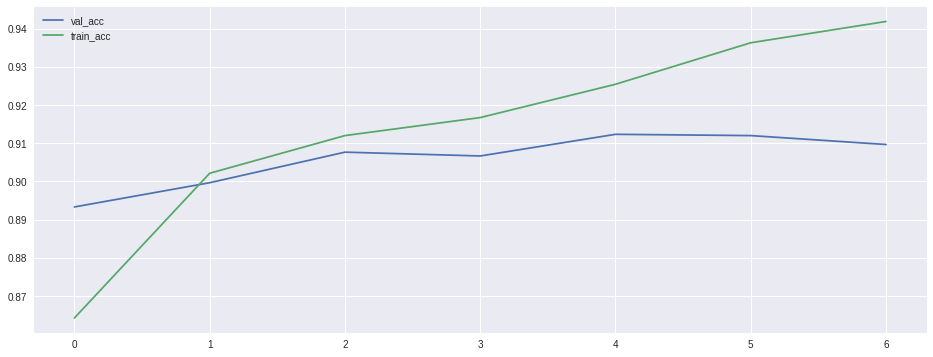

In [22]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

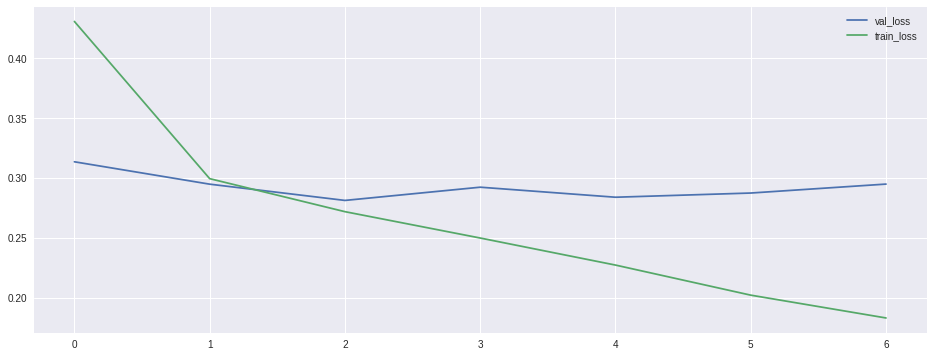

In [23]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [0]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [0]:
test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [29]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.9066

In [31]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.38      0.30      0.33        90
           1       0.93      0.97      0.95      8444
           2       0.81      0.59      0.68      1466

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.70      0.62      0.65     10000
weighted avg       0.90      0.91      0.90     10000
 samples avg       0.91      0.91      0.91     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
LSTM_PATH = 'drive/My Drive/Colab Notebooks/weights/lstm.h5'

In [0]:
model.save(LSTM_PATH)

#Redes convolucionales

In [33]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu')(inp)
x = k.layers.MaxPool1D(pool_size = 4)(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 10, kernel_size = 10, strides = 5, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
out = k.layers.Dense(3, activation='softmax')(x)



model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(k.optimizers.Nadam(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1645)         0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedding)       (None, 1645, 300)    15000000    content_input[0][0]              
__________________________________________________________________________________________________
conv1d_1 (

In [34]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=120, epochs=15,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2)], validation_split=0.3)

Train on 7000 samples, validate on 3000 samples
Epoch 1/15
7000/7000 [==============================] - 5s 704us/sample - loss: 0.3621 - acc: 0.8609 - val_loss: 0.2318 - val_acc: 0.9093
Epoch 2/15
7000/7000 [==============================] - 2s 339us/sample - loss: 0.1659 - acc: 0.9377 - val_loss: 0.1924 - val_acc: 0.9243
Epoch 3/15
7000/7000 [==============================] - 2s 339us/sample - loss: 0.0803 - acc: 0.9724 - val_loss: 0.2203 - val_acc: 0.9200
Epoch 4/15
7000/7000 [==============================] - 2s 335us/sample - loss: 0.0221 - acc: 0.9943 - val_loss: 0.2480 - val_acc: 0.9283
Epoch 5/15
7000/7000 [==============================] - 2s 329us/sample - loss: 0.0049 - acc: 0.9990 - val_loss: 0.3045 - val_acc: 0.9307
Epoch 6/15
7000/7000 [==============================] - 2s 327us/sample - loss: 0.0012 - acc: 0.9999 - val_loss: 0.3137 - val_acc: 0.9327
Epoch 7/15
7000/7000 [==============================] - 2s 328us/sample - loss: 4.2920e-04 - acc: 1.0000 - val_loss: 0.3352 

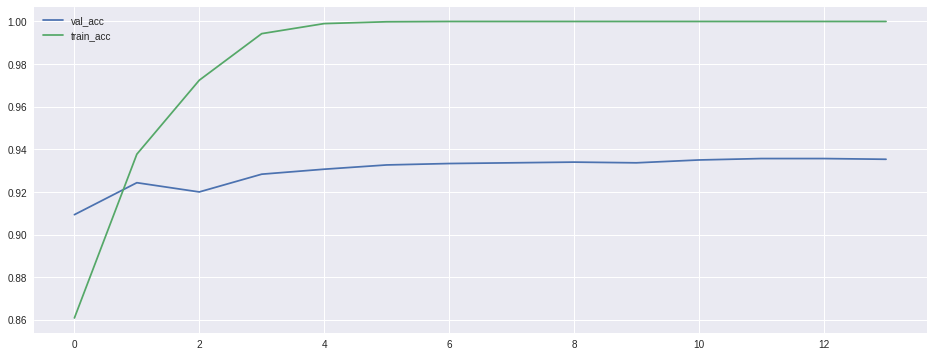

In [35]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

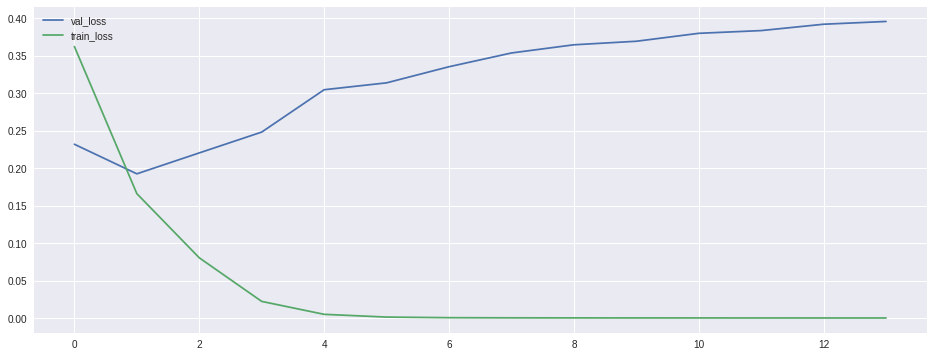

In [36]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [37]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.93

In [38]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.44      0.19      0.26        90
           1       0.95      0.97      0.96      8444
           2       0.81      0.74      0.77      1466

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.73      0.63      0.67     10000
weighted avg       0.93      0.93      0.93     10000
 samples avg       0.93      0.93      0.93     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
CONV_PATH = 'drive/My Drive/Colab Notebooks/weights/conv.h5'
model.save(CONV_PATH)